# Natural Language Processing Disaster Tweets

The purpose of this project is to create a classifier that will predict whether a tweet is about a real life disaster or not. The data consists of training and test data, where the train data has labels. This is a natural language processing problem. 

The first step is to load in the data. The data is in the "data" folder of this directory and there is a train and test csv which is the data for your classifier. Below I look at the size of the data.

In [88]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
total = len(train_df)+len(test_df)
print('Training Set Shape = {}'.format(train_df.shape))
print('Test Set Shape = {}'.format(test_df.shape))
print('Train % :', round(len(train_df)/(total),3))
print('Test % :', round(len(test_df)/(total),3))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)
Train % : 0.7
Test % : 0.3


## Exploratory Data Analysis

Next step is to take some time to understand the data with exploratory data analysis. 

In [89]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [90]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [91]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


There are non null values in all rows of the ID, Text and Target columns. I will only use these columns for my training since the test data does not have keyword or location for all entries. Lets look at the distribution between disaster and non disaster tweets in the training data. 

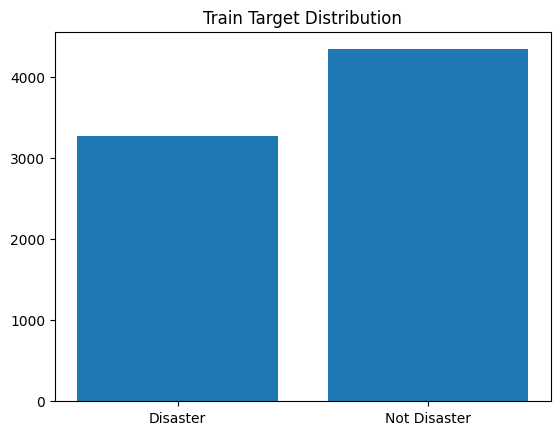

In [96]:
plt.bar(['Disaster', 'Not Disaster'], [train_df['target'].sum(), len(train_df)-train_df['target'].sum()])
plt.title('Train Target Distribution')
plt.show()

## Train Val Split

Next step is to split the training data into a train and validation dataset. I use 15% of the training data for validation. Test is already about 30% of the total data. 

In [46]:
X = train_df["text"]
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_df["text"]

print('Train % :', round(len(X_train)/(total),3))
print('Test % :', round(len(X_test)/(total),3))
print('Val % :', round(len(X_val)/(total),3))

Train % : 0.56
Test % : 0.3
Val % : 0.14


## Setup & Train the Model

Below I set parameters for the model and training. Then the model is created. I chose to use a Bert (https://keras.io/api/keras_nlp/models/bert/bert_classifier/) , or Bidirectional Encoder Representations from Transformers, because it has the ability to automatically preprocess raw inputs during fit(), predict() and evaluate(), which means much less data preperation for me. Additionally a Bert classifier is a suitable model for the problem. The data is preprocessed in a preprocessing layer using from_preset(). 
I chose a classic BERT model and the Distilled Bert model which has half the layers and runs faster without token-type embeddings or pooler. I will compare the results of each model on the dataset and use the best one. 

In [47]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
EPOCHS = 2

In [48]:
# Load a BERT model.
# Use a shorter sequence length.
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en_uncased",sequence_length=160,name="preprocessor_4_tweets")
# Pretrained classifier.
classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_en_uncased",preprocessor = preprocessor, num_classes=2)
classifier.summary()

classifier.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),metrics= ["accuracy"])

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         verbose = 1,
                         epochs=25, 
                         validation_data=(X_val, y_val))

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,483,778 (417.65 MB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6664s 34s/step - accuracy: 0.7115 - loss: 0.5596 - val_accuracy: 0.8372 - val_loss: 0.3986
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6397s 33s/step - accuracy: 0.8420 - loss: 0.3721 - val_accuracy: 0.8391 - val_loss: 0.3924
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6337s 33s/step - accuracy: 0.8805 - loss: 0.3078 - val_accuracy: 0.8359 - val_loss: 0.3936
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6288s 33s/step - accuracy: 0.9162 - loss: 0.2453 - val_accuracy: 0.8286 - val_loss: 0.4749
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6353s 33s/step - accuracy: 0.9338 - loss: 0.1971 - val_accuracy: 0.8352 - val_loss: 0.4970
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6244s 33s/step - accuracy: 0.9471 - loss: 0.1608 - val_accuracy: 0.8116 - val_loss: 0.6455
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6375s 33s/step - accuracy: 0.9546 - loss: 0.1361 - val_accuracy: 0.8070 - val_loss: 0.6676
Epoch 8/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6370s 33s/step - accuracy: 0.9646 - loss: 0

This model does not seem to be learning as I would like. As you can see the val loss is increasing and the val accuracy is staying about the same. I think that maybe I am not using the proper loss function for this model. I will see based on the results of the model predictions if the model has learned the data at all. 

In [58]:
classifier.save('bert_25 epoch.keras')

Now we have saved the BERT model and will begin training the DistilBERT model.

In [60]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor_d = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,sequence_length=160,name="preprocessor_4_tweets")
# Pretrained classifier.
classifier_d = keras_nlp.models.DistilBertClassifier.from_preset(preset,preprocessor = preprocessor_d, num_classes=2)
classifier_d.summary()

classifier_d.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',SparseCategoricalCrossentropy
    optimizer=keras.optimizers.Adam(1e-5),metrics= ["accuracy"])

# Fit
history_d = classifier_d.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         verbose = 1,
                         epochs=25, 
                         validation_data=(X_val, y_val))


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_8 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_8[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 2939s 15s/step - accuracy: 0.7004 - loss: 0.5715 - val_accuracy: 0.8431 - val_loss: 0.3938
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 2514s 13s/step - accuracy: 0.8404 - loss: 0.3763 - val_accuracy: 0.8490 - val_loss: 0.3818
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1837s 10s/step - accuracy: 0.8740 - loss: 0.3163 - val_accuracy: 0.8477 - val_loss: 0.3865
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1807s 9s/step - accuracy: 0.8966 - loss: 0.2791 - val_accuracy: 0.8424 - val_loss: 0.4028
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1822s 10s/step - accuracy: 0.9132 - loss: 0.2394 - val_accuracy: 0.8253 - val_loss: 0.4797
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1827s 10s/step - accuracy: 0.9283 - loss: 0.2010 - val_accuracy: 0.8221 - val_loss: 0.5384
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1833s 10s/step - accuracy: 0.9417 - loss: 0.1713 - val_accuracy: 0.8260 - val_loss: 0.5521
Epoch 8/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1835s 10s/step - accuracy: 0.9497 - loss: 0.

In [57]:
model.save('bert_distil.keras')

Now that there are two BERT models have been trained, I want to look at the results using a confusion matrix to see the results in terms of False Positives, True Positives, False Negatives and True Negatives. 

In [51]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

48/48 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step


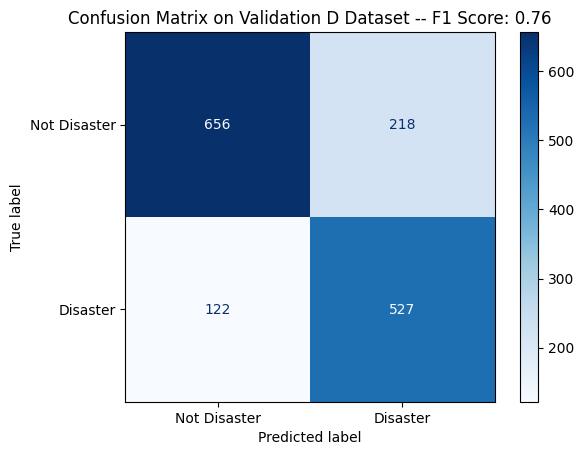

In [77]:
y_pred_val_d = classifier_d.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val, "Validation D")

48/48 ━━━━━━━━━━━━━━━━━━━━ 278s 6s/step


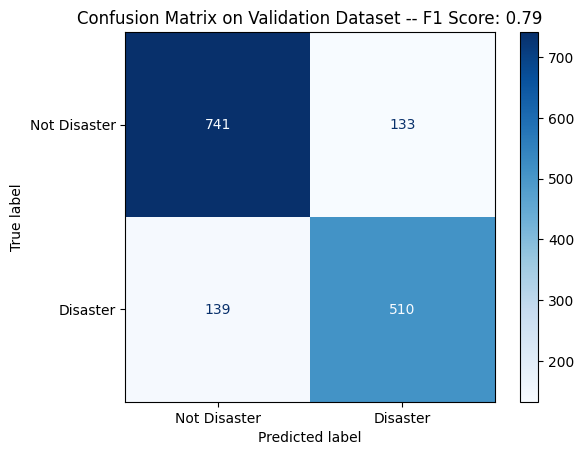

In [78]:
y_pred_val = classifier.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val, "Validation")

Based on these results it looks like the model definitelty learned the data in some sense even though I did not use the proper loss function. The original BERT model performed better than the DistilBERT. I will use original to predict the test data for my submission.

In [62]:
#Submission Results
y_test_pred = classifier.predict(X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 580s 6s/step


In [83]:
submission = pd.DataFrame({'id':test_df.id, 'target':np.argmax(y_test_pred, axis=1)})


In [84]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0


In [85]:
submission.to_csv('NLP_submission.csv', index = False)

## Conclusion

Although my BERT models did not get as good of results as I expected they did perform reasonable well with F1 scores of 0.76-0.79. Remember that the F1 score is equal to 2*(Precision*Recall/(Precision+Recall)). I could have trained more to get potentially better results, but did not have time to continue training. Additionally, if I could go back before training my model I would have included a callback to store my training results (accuracy, loss). I was unable to plot my training curves because I could not access these after training from the history variable I created. Although my model could have been improved I was 327 on the leaderboard out of 1225. 